<a href="https://colab.research.google.com/github/koll-ai/stable-diffusion-qrcode/blob/master/colabs/diffusers_qrcode_test_multicontrolnet_guidance_start_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows how to use controlnet guidance start/stop with diffusers pipeline.

Credits to user [holwech](https://github.com/holwech) for their [PR](https://github.com/huggingface/diffusers/pull/3770)

Checkout https://github.com/koll-ai/stable-diffusion-qrcode to generate qrcodes with this method in one line

In [ ]:
!pip install git+https://github.com/huggingface/diffusers accelerate transformers==4.30.0 qrcode
!pip install sdqrcode


# Generate the qrcode

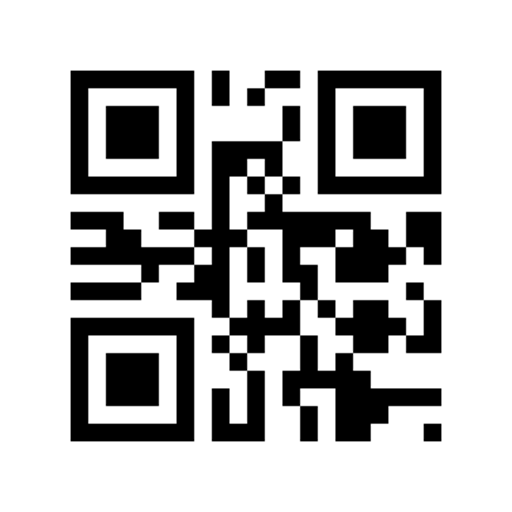

In [2]:

import qrcode
def generate_qrcode_img(
    error_correction: int = qrcode.constants.ERROR_CORRECT_L,
    box_size: int = 10,
    border: int = 4,
    fill_color: str = "black",
    back_color: str = "white",
    text: str = "https://koll.ai",
):
    qr = qrcode.QRCode(
        version=1,
        error_correction=error_correction,
        box_size=box_size,
        border=border,
    )
    qr.add_data(text)
    qr.make(fit=True)
    qr_img = qr.make_image(
        fill_color=fill_color,
        back_color=back_color,
    )

    # convert to pil
    qr_img = qr_img.convert("RGB")

    return qr_img

qrcode_img = generate_qrcode_img(text="https://koll.ai").resize((512,512))
qrcode_img

# Define Stable diffusion model and controlnets models

In [ ]:
from diffusers import (
    ControlNetModel,
    StableDiffusionControlNetPipeline,
    UniPCMultistepScheduler,
)
import torch
import transformers
from diffusers import UniPCMultistepScheduler
from diffusers import DPMSolverMultistepScheduler



controlnet_brightness = ControlNetModel.from_pretrained("ioclab/control_v1p_sd15_brightness")
controlnet_tile = ControlNetModel.from_pretrained("lllyasviel/control_v11f1e_sd15_tile")

# you can use another model but you might change the controlnets params
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "SG161222/Realistic_Vision_V2.0", controlnet=[controlnet_brightness, controlnet_tile]
).to('cuda')

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas='true')


# Define controlnet parameters and generate ai qrcode

  0%|          | 0/30 [00:00<?, ?it/s]

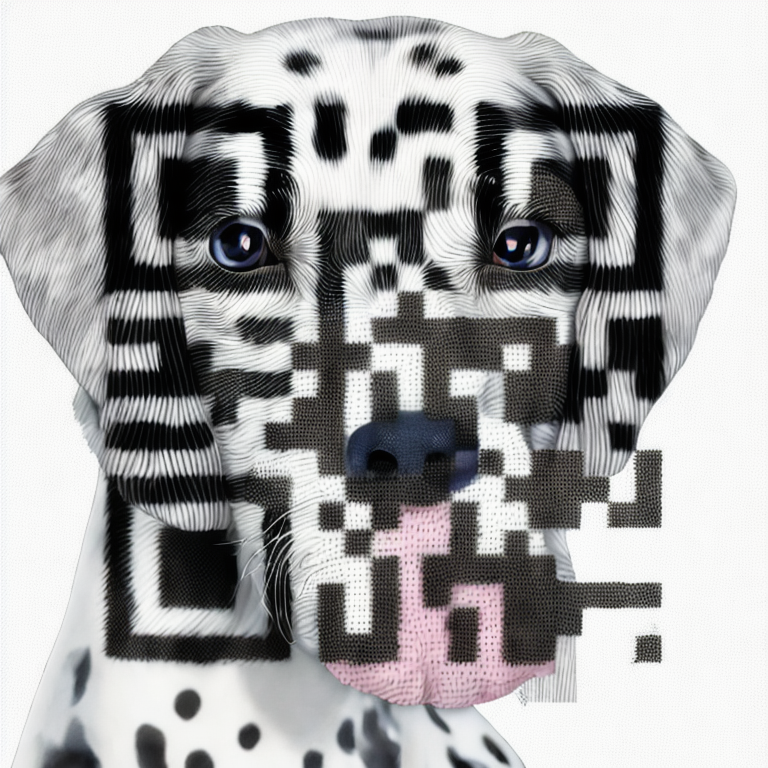

In [4]:
controlnets_weights = [0.35, 0.6]
controlnets_startstop = [(0,1), (0.3,0.7)]

guidance_starts = [val[0] for val in controlnets_startstop]
guidance_stops = [val[1] for val in controlnets_startstop]

res = pipe('a beautiful dalmatian portrait, front shot', image=[qrcode_img,qrcode_img],
           num_inference_steps=30, width=768, height=768,
           control_guidance_start=guidance_starts,
           control_guidance_end=guidance_stops,
           controlnet_conditioning_scale=controlnets_weights)

res.images[0]

# Downscale image so that it's more easily scannable

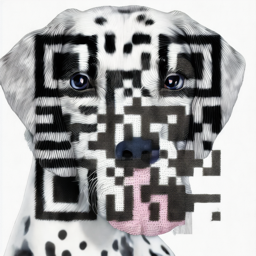

In [5]:
res.images[0].resize((256,256))